In [3]:
# Importing libraries for data handling, image processing, and deep learning
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms


In [4]:
# Setting a fixed seed for reproducibility across random operations
import random
import numpy as np
import torch

# Set the seed for reproducibility
seed = 42  # Chosen seed value for consistent results
random.seed(seed)  # Python's random module
np.random.seed(seed)  # NumPy's random module
torch.manual_seed(seed)  # PyTorch CPU
torch.cuda.manual_seed_all(seed)  # PyTorch GPU (all devices)

# Ensure reproducibility in data loader shuffling and other parallel computations
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [5]:
# Define paths for the dataset, data folder, and example files
csv_path = '/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/data.csv'
data_folder = '/kaggle/input/lgg-mri-segmentation/kaggle_3m'
eg_path = '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8113_19930809'
eg_img = '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_10.tif'
eg_mask = '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_10_mask.tif'


In [6]:
# Dataset class for loading and preprocessing brain MRI images and masks
class BrainDataset(Dataset):
    def __init__(self, path=None, transform=None):
        """
        Initialize the dataset by collecting and pairing images and masks.
        
        Args:
            path (str): Path to the directory containing patient folders with images and masks.
            transform (albumentations.Compose, optional): Transformation pipeline to apply to images and masks.
        """
        self.transform = transform
        self.images, self.masks = [], []

        # Exclude unnecessary files and gather valid patient directories
        self.patients = [file for file in os.listdir(path) if file not in ['data.csv', 'README.md']]

        # Collect all image and mask paths
        for patient in self.patients:
            patient_path = os.path.join(path, patient)
            if os.path.isdir(patient_path):
                for file in os.listdir(patient_path):
                    if "mask" in file.lower():
                        self.masks.append(os.path.join(patient_path, file))
                    else:
                        self.images.append(os.path.join(patient_path, file))
        
        # Ensure images and masks are sorted for correct pairing
        self.images = sorted(self.images)
        self.masks = sorted(self.masks)

    def __len__(self):
        # Return the total number of images
        return len(self.images)
    
    def __getitem__(self, idx):
        """
        Fetch a paired image and mask by index.
        
        Returns:
            tuple: (image, mask) where image is normalized and transformed.
        """
        # Load and normalize the image and mask
        image = cv2.imread(self.images[idx])
        image = np.array(image) / 255.0
        mask = cv2.imread(self.masks[idx], 0)  # Load mask in grayscale
        mask = np.array(mask) / 255.0
        
        # Apply transformations if provided
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        # Convert to PyTorch tensors and format appropriately
        image = image.transpose((2, 0, 1))  # Convert to channel-first format
        image = torch.from_numpy(image).float()
        
        mask = np.expand_dims(mask, axis=0)  # Add channel dimension to mask
        mask = torch.from_numpy(mask).float()
        
        return image, mask


In [5]:
# Define transformations and prepare dataset for training and testing
import albumentations as A  # Image augmentations

# Define train and test transformations
train_transform = A.Compose([
    A.Resize(width=256, height=256, p=1.0),  # Resize images to 256x256
    A.HorizontalFlip(p=0.5),  # Random horizontal flip
    A.VerticalFlip(p=0.5),  # Random vertical flip
    A.RandomRotate90(p=0.5),  # Random 90-degree rotation
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=10, p=0.5),  # Random shift, scale, and rotate
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.2),  # Adjust brightness/contrast
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),  # Add Gaussian noise
])
test_transform = A.Compose([
    A.Resize(width=256, height=256, p=1.0),  # Resize images to 256x256
])

# Step 1: Load the entire dataset
full_dataset = BrainDataset(path=data_folder, transform=None)

# Step 2: Split the dataset into training (80%) and testing (20%) subsets
train_size = int(0.8 * len(full_dataset))  # Calculate training size
test_size = len(full_dataset) - train_size  # Calculate testing size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Step 3: Apply transformations to train and test datasets
train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform

# Step 4: Create DataLoaders for batching and efficient data loading
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)  # Training DataLoader
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)  # Testing DataLoader

# Step 5: Fetch a batch for verification
images, masks = next(iter(train_loader))
print(images.shape)  # Expected: (batch_size, 3, 256, 256) or (batch_size, 1, 256, 256) for grayscale
print(masks.shape)   # Expected: (batch_size, 1, 256, 256)


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


torch.Size([16, 3, 256, 256])
torch.Size([16, 1, 256, 256])


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# Convolutional block: Conv2D -> BatchNorm -> ReLU
class convblock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(convblock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels, eps=1e-4)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.bn(self.conv(x)))
        return x

# Decoder block: Upsampling -> Skip connection -> Channel reduction -> Convolutions
class stackDecoder(nn.Module):
    def __init__(self, big_channel, channel1, channel2, kernel_size=3, padding=1):
        super(stackDecoder, self).__init__()
        self.upsample = nn.ConvTranspose2d(
            in_channels=big_channel,
            out_channels=big_channel,
            kernel_size=2,
            stride=2
        )
        self.reduce_channels = nn.Conv2d(big_channel + channel1, channel2, kernel_size=1)
        self.block = nn.Sequential(
            convblock(channel2, channel2, kernel_size, padding),
            convblock(channel2, channel2, kernel_size, padding),
        )

    def forward(self, x, dow_tensor):
        # Upsample the input
        x = self.upsample(x)
        # Resize skip connection to match the upsampled output
        dow_tensor = F.interpolate(dow_tensor, size=x.shape[2:], mode='bilinear', align_corners=False)
        # Concatenate upsampled input with the skip connection
        x = torch.cat([x, dow_tensor], dim=1)
        # Reduce channels and apply convolutional block
        x = self.reduce_channels(x)
        x = self.block(x)
        return x

# U-Net model with VGG16 as the encoder
class UnetVGG16(nn.Module):
    def __init__(self):
        super(UnetVGG16, self).__init__()
        # Load the pretrained VGG16 model
        vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        vgg_features = vgg16.features

        # Encoder: VGG16 feature layers divided into blocks
        self.down1 = nn.Sequential(*vgg_features[:5])   # Output: [64, 256, 256]
        self.down2 = nn.Sequential(*vgg_features[5:10]) # Output: [128, 128, 128]
        self.down3 = nn.Sequential(*vgg_features[10:17])# Output: [256, 64, 64]
        self.down4 = nn.Sequential(*vgg_features[17:24])# Output: [512, 32, 32]
        self.down5 = nn.Sequential(*vgg_features[24:31])# Output: [512, 16, 16]

        # Bottleneck layer
        self.center = convblock(512, 512)

        # Decoder blocks
        self.up5 = stackDecoder(big_channel=512, channel1=512, channel2=256)  # Output: [256, 32, 32]
        self.up4 = stackDecoder(big_channel=256, channel1=512, channel2=128)  # Output: [128, 64, 64]
        self.up3 = stackDecoder(big_channel=128, channel1=256, channel2=64)   # Output: [64, 128, 128]
        self.up2 = stackDecoder(big_channel=64, channel1=128, channel2=32)    # Output: [32, 256, 256]
        self.up1 = stackDecoder(big_channel=32, channel1=64, channel2=16)     # Output: [16, 256, 256]

        # Final output layer: Reduces to 1 channel for binary segmentation
        self.conv = nn.Conv2d(16, 1, kernel_size=1, bias=True)

    def forward(self, x):
        # Encoder forward pass
        down1 = self.down1(x)     # [64, 256, 256]
        down2 = self.down2(down1) # [128, 128, 128]
        down3 = self.down3(down2) # [256, 64, 64]
        down4 = self.down4(down3) # [512, 32, 32]
        down5 = self.down5(down4) # [512, 16, 16]

        # Bottleneck
        out = self.center(down5)  # [512, 16, 16]

        # Decoder forward pass
        up5 = self.up5(out, down5)  # [256, 32, 32]
        up4 = self.up4(up5, down4)  # [128, 64, 64]
        up3 = self.up3(up4, down3)  # [64, 128, 128]
        up2 = self.up2(up3, down2)  # [32, 256, 256]
        up1 = self.up1(up2, down1)  # [16, 256, 256]

        # Final output layer
        out = self.conv(up1)       # [1, 256, 256]
        out = torch.sigmoid(out)   # Apply sigmoid activation for binary segmentation
        return out


In [8]:
import torch
import torch.nn as nn

# Function to calculate the Dice coefficient metric between prediction and ground truth
def dice_coef_metric(pred, label, smooth=1e-6):
    """
    Computes the Dice coefficient for evaluating segmentation performance.

    Args:
        pred (torch.Tensor): Predicted segmentation map (binary mask).
        label (torch.Tensor): Ground truth segmentation map (binary mask).
        smooth (float): Smoothing factor to avoid division by zero.

    Returns:
        torch.Tensor: Dice coefficient.
    """
    intersection = 2.0 * (pred * label).sum()  # Intersection of predicted and ground truth
    union = pred.sum() + label.sum() + smooth  # Union of predicted and ground truth
    return intersection / union  # Dice coefficient formula

# Function to calculate the Dice coefficient loss
def dice_coef_loss(pred, label):
    """
    Computes the Dice loss, which is 1 - Dice coefficient.

    Args:
        pred (torch.Tensor): Predicted segmentation map (binary mask).
        label (torch.Tensor): Ground truth segmentation map (binary mask).

    Returns:
        torch.Tensor: Dice loss.
    """
    smooth = 1.0  # Smoothing factor to avoid division by zero
    intersection = 2.0 * (pred * label).sum() + smooth
    union = pred.sum() + label.sum() + smooth
    return 1 - (intersection / union)

# Function to calculate a combined loss: Binary Cross Entropy (BCE) + Dice loss
def bce_dice_loss(pred, label):
    """
    Combines BCE loss and Dice loss for training segmentation models.

    Args:
        pred (torch.Tensor): Predicted segmentation map (binary mask).
        label (torch.Tensor): Ground truth segmentation map (binary mask).

    Returns:
        torch.Tensor: Combined BCE + Dice loss.
    """
    dice_loss = dice_coef_loss(pred, label)  # Compute Dice loss
    bce_loss = nn.BCELoss()(pred, label)    # Compute Binary Cross Entropy loss
    return dice_loss + bce_loss  # Combine both losses

# Function to calculate the Tversky index metric
def tversky_metric(preds, labels, alpha=0.3, beta=0.7, smooth=1e-6):
    """
    Computes the Tversky index, a generalization of the Dice coefficient for imbalanced data.

    Args:
        preds (torch.Tensor): Predicted segmentation map (binary mask).
        labels (torch.Tensor): Ground truth segmentation map (binary mask).
        alpha (float): Weight for false positives.
        beta (float): Weight for false negatives.
        smooth (float): Smoothing factor to avoid division by zero.

    Returns:
        torch.Tensor: Tversky index.
    """
    # Flatten predictions and labels for element-wise operations
    preds = preds.view(-1)
    labels = labels.view(-1)

    # Calculate true positives, false positives, and false negatives
    TP = (preds * labels).sum()  # True Positives
    FP = ((1 - labels) * preds).sum()  # False Positives
    FN = (labels * (1 - preds)).sum()  # False Negatives

    # Compute the Tversky index
    tversky_index = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    return tversky_index


In [9]:
import torch
import torch.nn as nn
from torch.optim import Adam

# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the model
Unet_VGG16 = UnetVGG16()

# Enable multi-GPU support if available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    Unet_VGG16 = nn.DataParallel(Unet_VGG16)

# Move the model to the selected device
Unet_VGG16 = Unet_VGG16.to(device)

# Define the optimizer
optimizer = Adam(Unet_VGG16.parameters(), lr=1e-3)

# Initialize the learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)

# Variables to track the best metrics
best_dice_score = 0
best_tversky_score = 0

# Lists to store metrics for visualization
train_losses, train_dice_scores, train_tversky_scores = [], [], []
test_losses, test_dice_scores, test_tversky_scores = [], [], []

# Number of epochs
num_epochs = 50

# Training loop
for epoch in range(num_epochs):
    Unet_VGG16.train()  # Set model to training mode
    train_loss, train_dice, train_tversky = 0, 0, 0

    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data and target to the device
        data, target = data.to(device).float(), target.to(device).float()

        # Forward pass
        output = Unet_VGG16(data)

        # Compute the loss (BCE + Dice Loss)
        loss = bce_dice_loss(output, target)
        train_loss += loss.item()

        # Calculate metrics
        out_cut = (output >= 0.5).float()
        dice_value = dice_coef_metric(out_cut, target)
        tversky_value = tversky_metric(out_cut, target, alpha=0.7, beta=0.3)

        train_dice += dice_value.item() if isinstance(dice_value, torch.Tensor) else dice_value
        train_tversky += tversky_value.item() if isinstance(tversky_value, torch.Tensor) else tversky_value

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Average training metrics
    avg_train_loss = train_loss / len(train_loader)
    avg_train_dice = train_dice / len(train_loader)
    avg_train_tversky = train_tversky / len(train_loader)

    # Store metrics
    train_losses.append(avg_train_loss)
    train_dice_scores.append(avg_train_dice)
    train_tversky_scores.append(avg_train_tversky)

    # Testing loop
    Unet_VGG16.eval()  # Set model to evaluation mode
    test_loss, test_dice, test_tversky = 0, 0, 0

    with torch.no_grad():
        for data, target in test_loader:
            # Move data and target to the device
            data, target = data.to(device).float(), target.to(device).float()

            # Forward pass
            output = Unet_VGG16(data)

            # Compute the loss
            loss = bce_dice_loss(output, target)
            test_loss += loss.item()

            # Calculate metrics
            out_cut = (output >= 0.5).float()
            dice_value = dice_coef_metric(out_cut, target)
            tversky_value = tversky_metric(out_cut, target, alpha=0.7, beta=0.3)

            test_dice += dice_value.item() if isinstance(dice_value, torch.Tensor) else dice_value
            test_tversky += tversky_value.item() if isinstance(tversky_value, torch.Tensor) else tversky_value

    # Average testing metrics
    avg_test_loss = test_loss / len(test_loader)
    avg_test_dice = test_dice / len(test_loader)
    avg_test_tversky = test_tversky / len(test_loader)

    # Store metrics
    test_losses.append(avg_test_loss)
    test_dice_scores.append(avg_test_dice)
    test_tversky_scores.append(avg_test_tversky)

    # Step the scheduler
    scheduler.step(avg_test_dice)

    # Log metrics
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {avg_train_loss:.6f}, Train Dice: {avg_train_dice:.6f}, Train Tversky: {avg_train_tversky:.6f}, "
          f"Test Loss: {avg_test_loss:.6f}, Test Dice: {avg_test_dice:.6f}, Test Tversky: {avg_test_tversky:.6f}, "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Save the best model based on Dice Score
    if avg_test_dice > best_dice_score:
        best_dice_score = avg_test_dice
        torch.save(Unet_VGG16.state_dict(), "/kaggle/working/best_dice_model.pth")
        print(f"Best Dice model saved at epoch {epoch+1} with Dice score: {avg_test_dice:.6f}")

    # Save the best model based on Tversky Score
    if avg_test_tversky > best_tversky_score:
        best_tversky_score = avg_test_tversky
        torch.save(Unet_VGG16.state_dict(), "/kaggle/working/best_tversky_model.pth")
        print(f"Best Tversky model saved at epoch {epoch+1} with Tversky index: {avg_test_tversky:.6f}")


cuda


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 215MB/s]  


Using 2 GPUs!
Epoch 1/50, Train Loss: 1.25797116, Train Dice: 0.36896480, Train Tversky: 0.34892815, Test Loss: 1.06437635, Test Dice: 0.45728717, Test Tversky: 0.46179953, LR: 0.001000
Best Dice model saved at epoch 1 with Dice score: 0.45728717
Best Tversky model saved at epoch 1 with Tversky index: 0.46179953
Epoch 2/50, Train Loss: 0.92663009, Train Dice: 0.42353410, Train Tversky: 0.40573238, Test Loss: 0.77690224, Test Dice: 0.43883912, Test Tversky: 0.40318538, LR: 0.001000
Epoch 3/50, Train Loss: 0.68887814, Train Dice: 0.45222115, Train Tversky: 0.45126551, Test Loss: 0.61863382, Test Dice: 0.48334497, Test Tversky: 0.51332690, LR: 0.001000
Best Dice model saved at epoch 3 with Dice score: 0.48334497
Best Tversky model saved at epoch 3 with Tversky index: 0.51332690
Epoch 4/50, Train Loss: 0.61040550, Train Dice: 0.47223792, Train Tversky: 0.47878250, Test Loss: 0.55248789, Test Dice: 0.51994875, Test Tversky: 0.52152990, LR: 0.001000
Best Dice model saved at epoch 4 with Dice

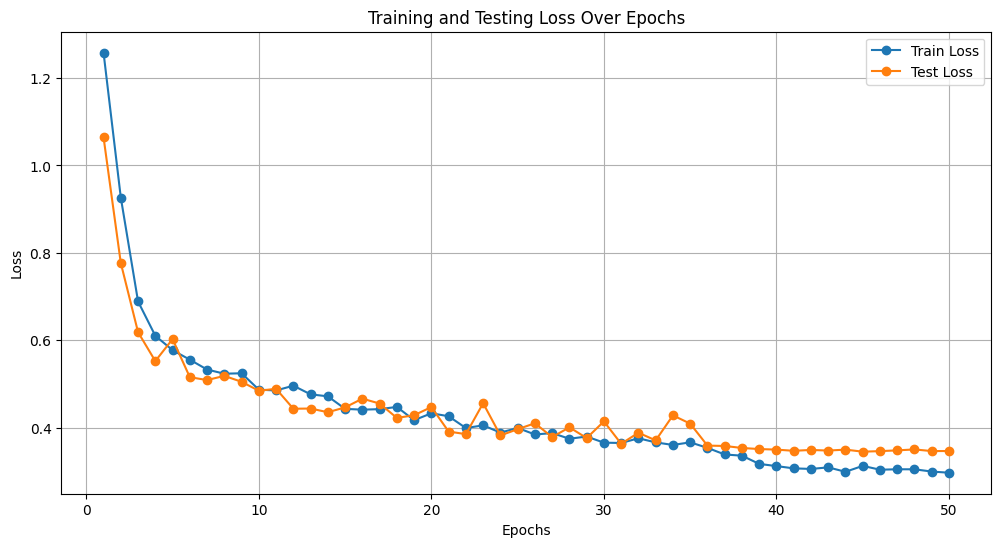

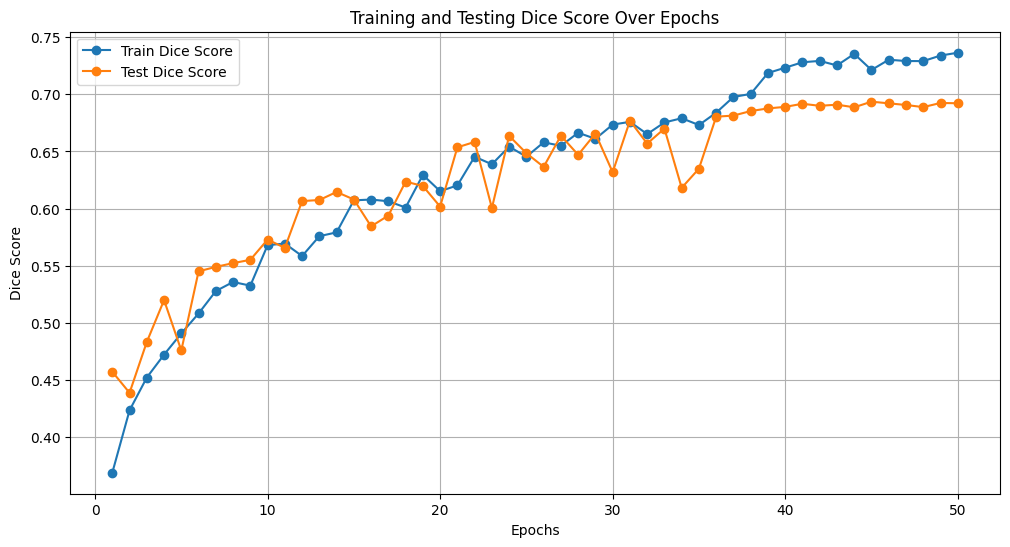

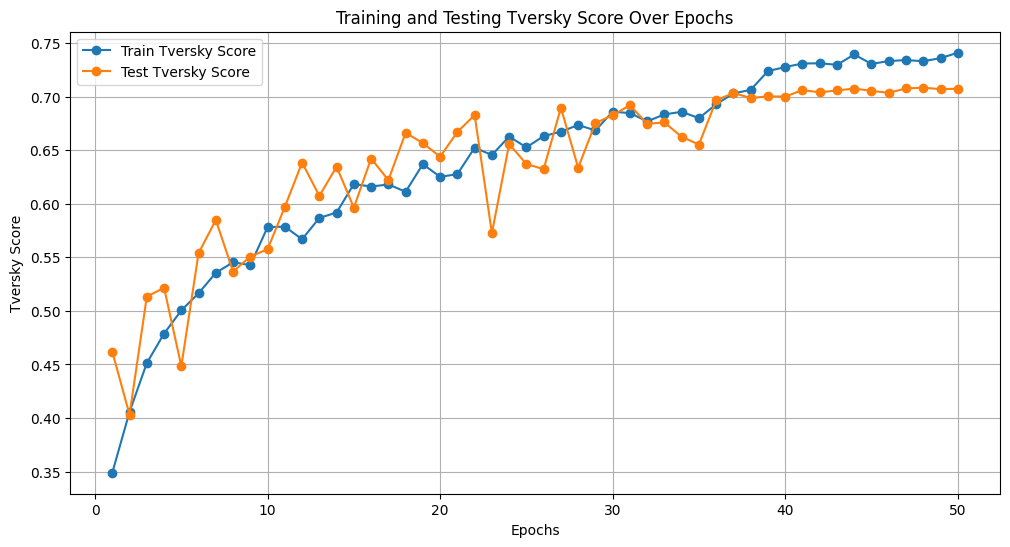

In [10]:
import matplotlib.pyplot as plt

# Plot training and testing losses
plt.figure(figsize=(12, 6))  # Set the size of the figure
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker='o')  # Plot training loss
plt.plot(range(1, num_epochs + 1), test_losses, label="Test Loss", marker='o')  # Plot testing loss
plt.xlabel("Epochs")  # Label for x-axis
plt.ylabel("Loss")  # Label for y-axis
plt.title("Training and Testing Loss Over Epochs")  # Title of the plot
plt.legend()  # Display the legend
plt.grid()  # Show grid for better readability
plt.show()  # Display the plot

# Plot training and testing Dice scores
plt.figure(figsize=(12, 6))  # Set the size of the figure
plt.plot(range(1, num_epochs + 1), train_dice_scores, label="Train Dice Score", marker='o')  # Plot training Dice score
plt.plot(range(1, num_epochs + 1), test_dice_scores, label="Test Dice Score", marker='o')  # Plot testing Dice score
plt.xlabel("Epochs")  # Label for x-axis
plt.ylabel("Dice Score")  # Label for y-axis
plt.title("Training and Testing Dice Score Over Epochs")  # Title of the plot
plt.legend()  # Display the legend
plt.grid()  # Show grid for better readability
plt.show()  # Display the plot

# Plot training and testing Tversky scores
plt.figure(figsize=(12, 6))  # Set the size of the figure
plt.plot(range(1, num_epochs + 1), train_tversky_scores, label="Train Tversky Score", marker='o')  # Plot training Tversky score
plt.plot(range(1, num_epochs + 1), test_tversky_scores, label="Test Tversky Score", marker='o')  # Plot testing Tversky score
plt.xlabel("Epochs")  # Label for x-axis
plt.ylabel("Tversky Score")  # Label for y-axis
plt.title("Training and Testing Tversky Score Over Epochs")  # Title of the plot
plt.legend()  # Display the legend
plt.grid()  # Show grid for better readability
plt.show()  # Display the plot


Using device: cpu


<ipython-input-16-6526f3a608c1>:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


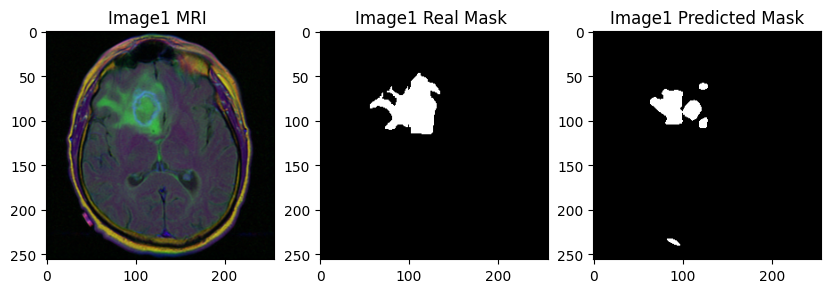

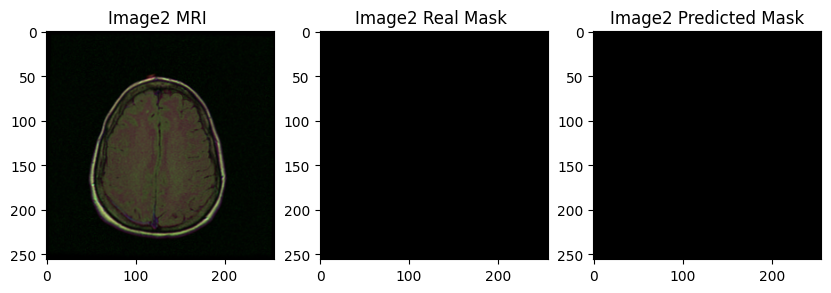

In [16]:
import cv2
import torch
import matplotlib.pyplot as plt
from albumentations import Compose, Resize, Normalize
from albumentations.pytorch import ToTensorV2
from collections import OrderedDict

# Function to load and transform image and mask
def load_and_transform(image_path, mask_path, transform):
    """
    Loads an image and its corresponding mask, applies transformations, and returns processed tensors.

    Args:
        image_path (str): Path to the input image.
        mask_path (str): Path to the corresponding mask.
        transform (albumentations.Compose): Transformation pipeline.

    Returns:
        tuple: Original image (RGB), mask (RGB), and transformed image tensor.
    """
    image = cv2.imread(image_path)  # Read image in BGR
    mask = cv2.imread(mask_path)    # Read mask in BGR

    # Convert to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    # Apply transformations
    transformed = transform(image=image)
    image_tensor = transformed["image"]  # Shape [3, 256, 256]
    
    return image, mask, image_tensor

# Function to visualize results
def plot_results(image_rgb, mask_rgb, pred_mask, title_prefix):
    """
    Visualizes the input image, real mask, and predicted mask.

    Args:
        image_rgb (ndarray): Original input image (RGB).
        mask_rgb (ndarray): Ground truth mask (RGB).
        pred_mask (ndarray): Predicted binary mask.
        title_prefix (str): Title prefix for the plots.
    """
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.title(f"{title_prefix} MRI")
    plt.imshow(image_rgb)

    plt.subplot(1, 3, 2)
    plt.title(f"{title_prefix} Real Mask")
    plt.imshow(mask_rgb)

    plt.subplot(1, 3, 3)
    plt.title(f"{title_prefix} Predicted Mask")
    plt.imshow(pred_mask, cmap='gray')

    plt.show()

# Paths to images and masks
paths = [
    {
        "image": "/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13.tif",
        "mask": "/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13_mask.tif",
        "title": "Image1"
    },
    {
        "image": "/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_26.tif",
        "mask": "/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_26_mask.tif",
        "title": "Image2"
    }
]

# Transformation pipeline
transform = Compose([
    Resize(256, 256),  # Resize to 256x256
    Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255),  # Normalize pixel values
    ToTensorV2()  # Convert to PyTorch tensor
])

# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load model and set to evaluation mode
model = UnetVGG16().to(device)
model.eval()

# Load checkpoint and handle DataParallel "module." prefix issue
checkpoint_path = "/kaggle/input/unet-vgg-dice/pytorch/default/1/best_dice_model.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)

# Remove "module." prefix if needed
new_state_dict = OrderedDict()
for k, v in checkpoint.items():
    name = k[len("module."):] if k.startswith("module.") else k
    new_state_dict[name] = v

model.load_state_dict(new_state_dict, strict=True)

# Process and visualize images and masks
for path in paths:
    # Load and transform data
    image, mask, image_tensor = load_and_transform(path["image"], path["mask"], transform)
    
    # Prepare input for the model
    image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension, shape [1, 3, 256, 256]

    # Generate predictions
    with torch.no_grad():
        output = model(image_tensor.float())  # Model output, shape [1, 1, 256, 256]
        output_mask = (output >= 0.5).float()  # Threshold for binary mask

    # Convert predictions to numpy
    predicted_mask_np = output_mask.squeeze().cpu().numpy()  # Shape [256, 256]

    # Resize the real mask for visualization
    mask_rgb_resized = cv2.resize(mask, (256, 256))

    # Plot results
    plot_results(image, mask_rgb_resized, predicted_mask_np, path["title"])
